In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from app.tools.models.select_llms import get_llms

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)
llm_config = {
    "provider":"openai",
    "model":"gpt-4o-ca"
}
llm = get_llms(llm_config)
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [3]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()


Assistant: 截至目前，我对“langgraph”这个术语并没有具体的信息。可能是因为它是一个非常新颖的概念、特定领域的术语，或者是一个尚未广泛传播的术语。

如果你能提供更多的上下文或详细信息，我可能可以更好地帮助你理解这个概念。比如，它是涉及到计算机科学、语言学、数据可视化，还是其他领域？任何额外的信息都会有所帮助。


KeyboardInterrupt: 

In [1]:
from langchain_community.tools.tavily_search import TavilySearchResults
import os

os.environ["TAVILY_API_KEY"] = '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'
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making ...'},
 {'url': 'https://langchain-ai.github.io/langgraph/',
  'content': 'LangGraph is framework agnostic (each node is a regular python function). It extends the core Runnable API (shared interface for streaming, async, and batch calls) to make it easy to: Seamless state management across multiple turns of conversation or tool usage. The ability to flexibly route between nodes based on dynamic criteria.'}]

In [4]:
from app.tools.models.select_llms import get_llms
llm_config = {
    "provider":"openai",
    "model":"gpt-4o-ca"
}
llm = get_llms(llm_config)
llm_with_tools = llm.bind_tools(tools)

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [6]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [7]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

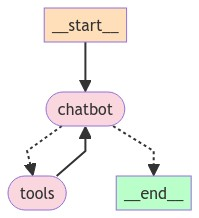

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [{"url": "https://langchain-ai.github.io/langgraph/tutorials/", "content": "Basic Reflection: Prompting the agent to reflect on and revise its outputs. Reflexion: Critiquing missing and superfluous details to guide next steps. Language Agent Tree Search: Using reflection and rewards to drive a tree search over agents. Self-Discovering Agent: Analyzing an agent that learns about its own capabilities."}, {"url": "https://blog.csdn.net/weixin_41496173/article/details/139023846", "content": "1.\u4ec0\u4e48\u662fLangGraph\uff1f. \u9996\u5148\u4e00\u53e5\u8bdd\u6982\u62ecLangGraph\uff1a\u53ef\u4ee5\u5b9e\u73b0\u57fa\u4e8eLLM\u667a\u80fd\u52a9\u624b\uff08LLM Agent\uff09\u7684\u795e\u4ed9\u6846\u67b6!. LangGraph\u662f\u5728LLM\u548cLangChain\u7684\u57fa\u7840\u4e4b\u4e0a\u53d1\u5c55\u800c\u6765\uff0cLangGraph\u5e93\u672c\u8eab\u57fa\u4e8eLangChain\u5e93\uff0c\u5982\u4e0b\u56fe\u6240\u793a\u3002. \u5982\u679c\u4ec5\u4f7f\u7528LLM\uff0c\u4e00\u822c\u7528\u4e8e\u5b9e\u73b0 

KeyboardInterrupt: 

In [12]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
llm_config = {
    "provider":"openai",
    "model":"gpt-4o-ca"
}
llm = get_llms(llm_config)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)

In [14]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_SMqqfSNyCyB2abyQdwpUua5n)
 Call ID: call_SMqqfSNyCyB2abyQdwpUua5n
  Args:
    query: LangGraph overview
  tavily_search_results_json (call_lwR0Gz4RVuJSPgAKTIBBVedq)
 Call ID: call_lwR0Gz4RVuJSPgAKTIBBVedq
  Args:
    query: LangGraph programming language features
  tavily_search_results_json (call_ezBwrsw01Xdav18I6Qi54QpN)
 Call ID: call_ezBwrsw01Xdav18I6Qi54QpN
  Args:
    query: LangGraph use cases
  tavily_search_results_json (call_FzISQqhJdcmnapUdGI8yndRF)
 Call ID: call_FzISQqhJdcmnapUdGI8yndRF
  Args:
    query: LangGraph tutorials
